In [165]:
import scipy.stats as stat
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

In [160]:
n = 200
alpha = 0.05
k=8
u_half_alpha = -stat.norm.ppf(alpha / 2)
t_half_alpha = -stat.t.ppf(q=alpha / 2, df=n-2)

In [167]:
def in_range(x, interval):
    a, b = interval
    if a <= x <= b:
        return True
    return False

def pearson_coef(x, y):
    return 1 / (n-1) * sum((x - np.mean(x)) * (y - np.mean(y)) / (np.std(x) * np.std(y)))

def corr_conf_int(r):
    z = 0.5 * np.log((1 + r) / (1 - r))
    z_L = z - u_half_alpha * (n-3)**-0.5
    z_U = z + u_half_alpha * (n-3)**-0.5
    r_low = (np.exp(2 * z_L) - 1) / (np.exp(2 * z_L) + 1)
    r_high = (np.exp(2 * z_U) - 1) / (np.exp(2 * z_U) + 1)
    return r_low, r_high

In [163]:
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


def group_data(data, k):
    x0 = math.floor(min(data))
    xn = math.ceil(max(data))
    bounds = [x0 + i * (xn - x0) / k for i in range(k + 1)]
    intervals = list(pairwise(bounds))
    invervals_mids = [(a + b) / 2 for (a, b) in intervals]
    grouped = np.zeros(np.size(data))
    for i in range(np.size(data)):
        entry_group = [j for j in range(k) if in_range(data[i], intervals[j])][0]
        grouped[i] = invervals_mids[entry_group]
    return grouped

In [174]:
def print_correlation(x,y,k):
    r = pearson_coef(x, y)

    r_low, r_high = corr_conf_int(r)
    print(f'ungrouped')
    print(f'plug-in estimation:{r}')
    print(f'lower bound:{r_low}')
    print(f'higher bound:{r_high}')

    x_group = group_data(x, k)
    y_group = group_data(y, k)
    r_group = pearson_coef(x_group, y_group)
    r_group_low, r_grop_high = corr_conf_int(r_group)
    print('\ngrouped:')
    print(f'plug-in estimation:{r_group}')
    print(f'lower bound:{r_group_low}')
    print(f'higher bound:{r_grop_high}')

# Confidence intervals

## Poisson parameter
$\overline{x_n} - u_{\alpha/2}n^{-0.5} \le \lambda \le \overline{x_n} + u_{\alpha/2}n^{-0.5}$ 

In [3]:
poisson_param = 6
poisson = np.random.default_rng().poisson(poisson_param, n)
poission_high = np.mean(poisson) + u_half_alpha / n**0.5
poission_low = np.mean(poisson) - u_half_alpha / n**0.5

print(f'lower bound:{poission_low}')
print(f'higher bound:{poission_high}')

lower bound:5.9264096175650325
higher bound:6.203590382434968


## Binomial parameter
$\frac{m}{n} - \frac{u_{\alpha/2}}{n}\sqrt{\frac{m(n-m)}{n}}\le 
    p 
\le \frac{m}{n} + \frac{u_{\alpha/2}}{n}\sqrt{\frac{m(n-m)}{n}}$

In [4]:
p = 0.4
binom = np.random.binomial(n=n, p=p)
m=np.sum(binom)
binom_low = m / n - u_half_alpha * (m * (n - m) / n)**0.5 / n
binom_high =  m / n + u_half_alpha * (m * (n - m) / n)**0.5 / n


print(f'lower bound:{binom_low}')
print(f'higher bound:{binom_high}')

lower bound:0.3418366341527243
higher bound:0.47816336584727565


## Exponential's parameter

$\frac{1}{\overline{x_n}} - \frac{u_{\alpha/2}}{\overline{x_n}\sqrt{n}} \le 
\lambda
\le \frac{1}{\overline{x_n}} + \frac{u_{\alpha/2}}{\overline{x_n}\sqrt{n}}
$

In [5]:
exp_param = 7
exp = np.random.default_rng().exponential(1 / exp_param, n)
exp_low = (1 - u_half_alpha / n**0.5) / np.mean(exp)
exp_high = (1 + u_half_alpha / n**0.5) / np.mean(exp)

print(f'lower bound:{exp_low}')
print(f'higher bound:{exp_high}')

lower bound:6.841856962852639
higher bound:9.043400929188746


# Kernel pdf estimation

## Gauss distr, gauss kernel

In [41]:
def gauss_kernel(x, h, sample):
    return 1 / (n * h) * sum([stat.norm.pdf((x - x_i) / h) for x_i in sample])

def uniform_pdf(x, a, b):
    return 1 / (b - a) if a<=x<=b else 0

def uniform_kernel(x, h, sample):
    return 1 / (n * h) * sum([uniform_pdf((x - x_i) / h, -1, 1) for x_i in sample])

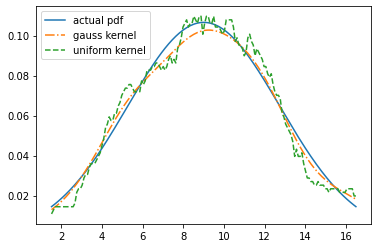

In [48]:
gauss_exp = 9
gauss_var = 14
gauss = stat.norm.rvs(loc=gauss_exp, scale=gauss_var**0.5,size=n)

h = 1.06 * np.std(gauss) / n**0.2
grid = np.linspace(start = gauss_exp - 2 * gauss_var**0.5, 
                   stop = gauss_exp + 2 * gauss_var**0.5, 
                   num = 170)
actual_distr = np.array([stat.norm.pdf(x, loc=gauss_exp, scale=gauss_var**0.5) for x in grid])
gauss_kernel_est = np.array([gauss_kernel(x, h, gauss) for x in grid])
uniform_kernel_est = np.array([uniform_kernel(x, h, gauss) for x in grid])
plt.plot(grid, actual_distr, '-', grid, gauss_kernel_est, '-.', grid, uniform_kernel_est, '--')
plt.legend(['actual pdf', 'gauss kernel', 'uniform kernel'])
plt.show()

## Uniform distr, gauss and uniform kernel

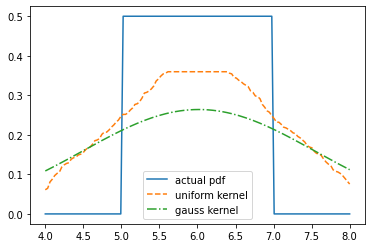

In [49]:
a = 5
b = 7
uniform = np.random.default_rng().uniform(low=a, high=b, size=n)

grid = np.linspace(start = a - 1, stop = b + 1, num = 130)
actual_distr = np.array([uniform_pdf(x, a, b) for x in grid])
uniform_kernel_est = np.array([uniform_kernel(x, h, uniform) for x in grid])
gauss_kernel_est = np.array([gauss_kernel(x, h, uniform) for x in grid])
plt.plot(grid, actual_distr, '-', grid, uniform_kernel_est, '--', grid, gauss_kernel_est, '-.')
plt.legend(['actual pdf', 'uniform kernel', 'gauss kernel'])
plt.show()

# Linear regression

## Gauss noise

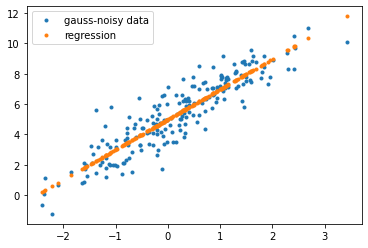

In [168]:
x = stat.norm.rvs(loc=0, scale=1,size=n)
x_group = group_data(x,k)
gauss_noise = stat.norm.rvs(loc=0, scale=1,size=n)

y_gauss = 5 + 2 * x + gauss_noise
regr_gauss = stat.linregress(x, y=y_gauss)

plt.plot(x, y_gauss, '.')
plt.plot(x, regr_gauss.intercept + regr_gauss.slope*x, '.')
plt.legend(['gauss-noisy data', 'regression'])
plt.show()

In [175]:
print_correlation(x, y_gauss, k)

ungrouped
plug-in estimation:0.9109588836149499
lower bound:0.8839362359657831
higher bound:0.9319173277302615

grouped:
plug-in estimation:0.8658196786769586
lower bound:0.8263428516117652
higher bound:0.8968293376655412


## Uniform noise

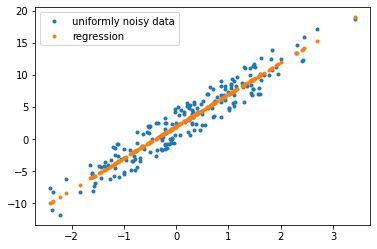

In [171]:
a = -3
b = 3
uniform_noise = np.random.default_rng().uniform(low=a, high=b, size=n)

y_uniform = 2 + 5 * x + uniform_noise
regr_uniform = stat.linregress(x, y=y_uniform)

plt.plot(x, y_uniform, '.')
plt.plot(x, regr_uniform.intercept + regr_uniform.slope*x, '.')
plt.legend(['uniformly noisy data', 'regression'])
plt.show()

In [176]:
print_correlation(x, y_uniform, k)

ungrouped
plug-in estimation:0.9593255429560485
lower bound:0.9465710520816999
higher bound:0.9690836558078234

grouped:
plug-in estimation:0.9032844288081842
lower bound:0.8740861630133772
higher bound:0.9259793105056422


## Cauchy noise

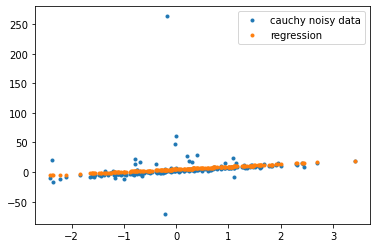

In [178]:
cauchy_noise = stat.cauchy.rvs(loc = 0, scale = 1, size=n)

y_cauchy = 2 + 5 * x + cauchy_noise
regr_cauchy = stat.linregress(x, y=y_cauchy)

plt.plot(x, y_cauchy, '.')
plt.plot(x, regr_cauchy.intercept + regr_cauchy.slope*x, '.')
plt.legend(['cauchy noisy data', 'regression'])
plt.show()

In [179]:

print_correlation(x, y_cauchy, k)

ungrouped
plug-in estimation:0.2271679358197277
lower bound:0.09130461471798912
higher bound:0.35472878305139344

grouped:
plug-in estimation:0.08482728995043828
lower bound:-0.054555793725773384
higher bound:0.22096773056700886
